# Africa Conflict Data Inspection

In [1]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plot
import time
%matplotlib inline

## Africa Conflict Data

In [2]:
africa_all = pd.read_excel('data/Africa_1997-2018_upd-Jul9.xlsx')
print("Length=%s" % len(africa_all))

Length=163416


In [3]:
africa_all.head(3)

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,ADMIN3,LOCATION,LATITUDE,LONGITUDE,GEO_PRECISION,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP
0,12,ALG1,1,1997-01-01,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Douaouda,36.6725,2.7894,1,www.algeria-watch.org,National,5 January: Beheading of 5 citizens in Douaouda...,5,1524054024
1,12,ALG2,2,1997-01-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Hassasna,36.1333,0.8833,1,www.algeria-watch.org,National,Two citizens were beheaded in Hassasna.,2,1524054024
2,12,ALG3,3,1997-01-03,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,NaN,Algiers,36.7525,3.0420,3,www.algeria-watch.org,National,Two citizens were killed in a raid on the vill...,2,1524054024


After inspecting the data, EVENT_ID_CNTY seems to contain a country like field, but there are no features that represent the exact country.  Granted, borders can shift, later we will join this data to a shapefile to identify which country borders currently represent the data.  Next we will reduce the data to points that only contain 4 or less fatalities, removing results that could be considered "Mass Casualty Incidents".

In [4]:
max_fatalities = 4
africa = africa_all.loc[africa_all['FATALITIES'] <= max_fatalities]

print("Count=%s Fatalities=%s" % (len(africa), africa.FATALITIES.sum()))

Count=144679 Fatalities=63368


Lets take a moment for the excluded data

In [5]:
excluded = africa_all.loc[africa_all['FATALITIES'] > max_fatalities]

print("Count=%s Fatalities=%s" % (len(excluded), excluded.FATALITIES.sum()))

Count=18737 Fatalities=671460


Most of the fatalities in the dataset are from incidents that can be considered Mass Casualty

## Africa Shape File

In [6]:
africa_map = gp.read_file('data/Africa_SHP/Africa.shp')
len(africa_map['COUNTRY'].unique())

52

In [7]:
africa_map.head()

,ID,CODE,COUNTRY,geometry
0,1,ALG,Algeria,"POLYGON ((-5.7636199999979 25.58624999999302, ..."
1,2,ANG,Angola,"POLYGON ((13.36632442474365 -8.32172966003418,..."
2,3,ANG,Angola,POLYGON ((12.80576000000292 -4.806490000002668...
3,4,ANG,Angola,POLYGON ((11.76834011077881 -16.79932975769043...
4,5,ANG,Angola,POLYGON ((12.89840030670166 -5.988018989562988...


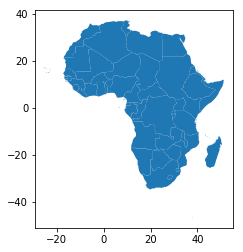

In [8]:
africa_map.plot()

/Users/adamhunter/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/adamhunter/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


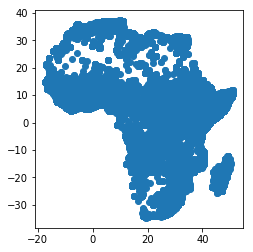

In [9]:
from shapely.geometry import Point

africa['Coordinates'] = list(zip(africa.LONGITUDE, africa.LATITUDE))
africa['Coordinates'] = africa['Coordinates'].apply(Point)
points = gp.GeoDataFrame(africa, geometry='Coordinates')

points.plot()

Ensure both of the datasets are using the same projection.  (It seems likely as the plot similarities, but lets ensure there won't be any distortion for sure).

In [10]:
from fiona.crs import from_epsg

points.crs = from_epsg(4326)
africa_map.crs = from_epsg(4326)
points.crs == africa_map.crs

True

## Point-in-Polygon Spatial Join

In [11]:
t1 = time.time()
join = gp.sjoin(points, africa_map, how="inner", op="within")
t2 = time.time()
print("Function=sjoin, Time=%s, Points=%s" % (t2 - t1, len(points)))

Function=sjoin, Time=5.9045586585998535, Points=144679


In [12]:
join.head(3)

,ISO,EVENT_ID_CNTY,EVENT_ID_NO_CNTY,EVENT_DATE,YEAR,TIME_PRECISION,EVENT_TYPE,ACTOR1,ASSOC_ACTOR_1,INTER1,...,SOURCE,SOURCE_SCALE,NOTES,FATALITIES,TIMESTAMP,Coordinates,index_right,ID,CODE,COUNTRY_right
1,12,ALG2,2,1997-01-02,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,Two citizens were beheaded in Hassasna.,2,1524054024,POINT (0.8833 36.1333),0,1,ALG,Algeria
2,12,ALG3,3,1997-01-03,1997,1,Violence against civilians,GIA: Armed Islamic Group,NaN,2,...,www.algeria-watch.org,National,Two citizens were killed in a raid on the vill...,2,1524054024,POINT (3.042 36.7525),0,1,ALG,Algeria
5,12,ALG6,6,1997-01-06,1997,1,Battle-No change of territory,Police Forces of Algeria (1994-1999),NaN,1,...,www.algeria-watch.org,National,4 armed men were killed by security forces in ...,4,1524054024,POINT (2.9219 36.8028),0,1,ALG,Algeria


In [13]:
join.COUNTRY_right.isna().sum()

0

All of the points have been joined to a polygon in the shapefile.

Next we will create a plot of all of the points layed over the shapefile, increasing the markersize based on the fatalities

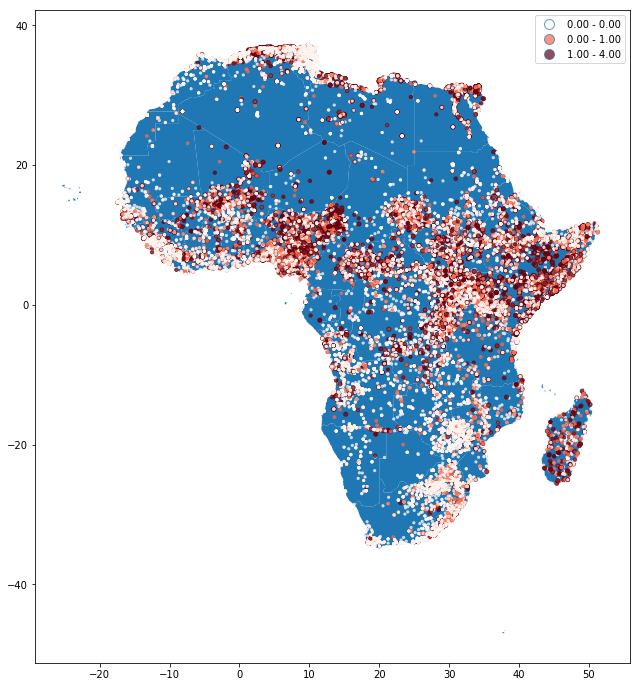

In [17]:
f, ax = plot.subplots(1)

plot_africa = africa_map.plot(ax=ax)
plot_points = join.plot(ax=ax, column='FATALITIES', cmap='Reds', scheme='quantiles', markersize=join.FATALITIES*3+5, alpha=0.7, legend=True)

f.set_size_inches(12,12)

plot.show()

Finally we will create a chloropleth of the data but grouping the sums of fatalties per country.

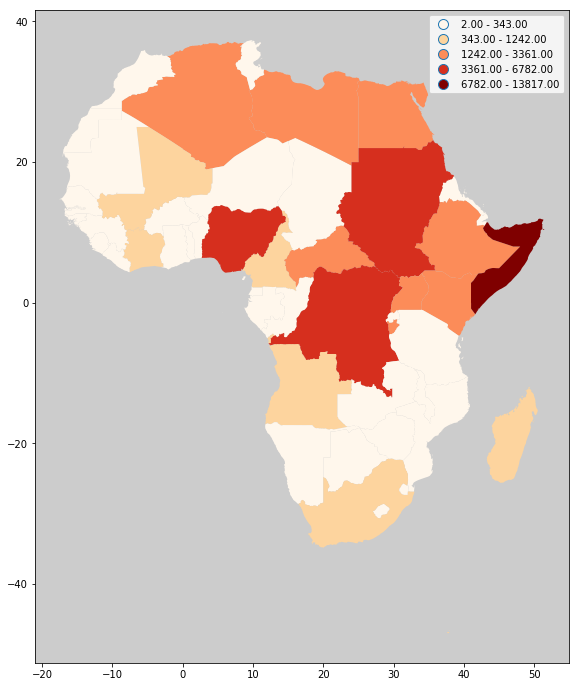

In [18]:
fatals = join[['COUNTRY_right', 'FATALITIES']].groupby('COUNTRY_right').sum()
fatals = gp.GeoDataFrame(fatals.merge(africa_map, left_on='COUNTRY_right', right_on='COUNTRY'))

f, ax = plot.subplots(1)
f.set_size_inches(12,12)
ax.set_facecolor('#cccccc')
fatals.plot(ax=ax, column='FATALITIES', cmap='OrRd', scheme='fisher_jenks', legend=True)